In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq

# from numba import jit

<h3>Step 1: Build likelihood function:</h3>
The simplest Likelihood function (without considering nuisance parameters) is given by:

$$ L(\mu) = \frac{(\mu s + b)^{n}}{n!}e^{-(\mu s + b)} $$


In [2]:
# define factorial
# likelihood function
def likelihood(n, nb, ns, mu):
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events
    nb : # of background events
    ns : # of signal events
    mu : strength parameter
    '''
    e = nb + mu*ns
#     prob = poisson.pmf(n, ntot)
    prob = e**n * np.exp(-(e)) / factorial(n)
    
    return prob

In [3]:
def muHat(n, nb, ns):
    
    muHat = (n - nb)/ns
    return muHat

In [4]:
def profLikelihood(n, nb, ns, mu):
    
    L = likelihood(n, nb, ns, mu)
    Lmax = likelihood(n, nb, ns, muHat(n, nb, ns))
    return L/Lmax

In [5]:
#find a way to select only positive muHat
def qtest(n, nb, ns):
    
    if muHat(n, nb, ns) > 0:
        return -2.*np.log(profLikelihood(n, nb, ns, 1))
    else:
        return 0

In [6]:
# Set known values
ns = 14.933117
nb = 38.836
mu = 1.
nobs = 40.
nsim = int(1e6)

t_mu = []

# Generate samples under null hypothesis
def genData(mu, nb, ns, nsim):
    ngen = np.random.poisson(lam=mu*ns+nb, size=nsim) 
    return ngen


pseudoN = genData(mu, nb, ns, nsim)

In [7]:
%%time
q0 = np.vectorize(qtest)(pseudoN, np.full(nsim, nb), np.full(nsim, ns))

CPU times: user 4.82 s, sys: 23 ms, total: 4.85 s
Wall time: 4.85 s


In [8]:
qobs = qtest(nobs, nb, ns)
qvals = np.linspace(q0.min(), q0.max(), 100)

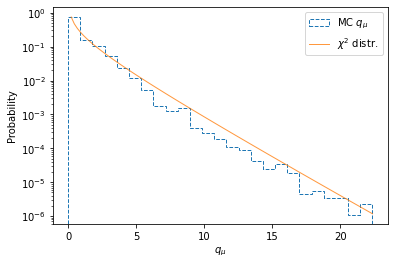

In [9]:
# Plot histogram
hist = plt.hist(q0, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
plt.plot(qvals, chi2.pdf(qvals, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')
# plt.vlines(qobs, 0, 1, 'red', label=r'$q_{obs}$')

plt.legend()
plt.ylabel('Probability')
plt.xlabel(r'$q_{\mu}$')
plt.yscale('log')
plt.show()

In [10]:
# p-value from histogram
pval_mc = len(q0[q0>=qobs])/len(q0)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print(r'p-value following MC method:', pval_mc)
print('p-value from chi squared distribution:', pval_chi)

p-value following MC method: 0.041061
p-value from chi squared distribution: 0.049079006579640705


Let us now test different values of s and b:

In [11]:
ns1 = random.uniform(20, 30)
nb1 = random.uniform(20, 40)

In [12]:
n = genData(mu, nb1, ns1, nsim)
q01 = np.vectorize(qtest)(n, np.full(nsim, nb1), np.full(nsim, ns1))

In [13]:
qvals1 = np.linspace(q01.min(), q01.max(), 100)

In [14]:
ns2 = random.uniform(20, 30)
nb2 = random.uniform(40, 50)

In [15]:
n2 = genData(mu, nb2, ns2, nsim)
q02 = np.vectorize(qtest)(n2, np.full(nsim, nb2), np.full(nsim, ns2))

In [16]:
qvals2 = np.linspace(q02.min(), q02.max(), 100)

In [17]:
print(ns1, nb1)
print(ns2, nb2)

20.370802203299565 31.77161321004685
22.615863234803 49.320536749828925


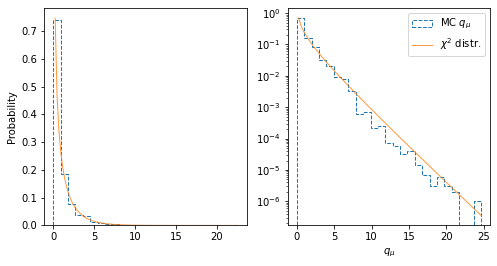

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(q01, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
ax1.plot(qvals1, chi2.pdf(qvals1, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')

ax2.hist(q02, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
ax2.plot(qvals2, chi2.pdf(qvals2, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')

plt.legend()
ax1.set_ylabel('Probability')
ax2.set_xlabel(r'$q_{\mu}$')
plt.yscale('log')
plt.show()